In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = yf.download (tickers=['AAPL'], period='1y')
y = df['Close'].fillna (method='ffill')
y = y.values.reshape(-1, 1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-56dd78224188>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['Close'].fillna (method='ffill')


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

In [ ]:
n_lookback = 60 # jumlah data input (lookback period)
n_forecast = 60 # jumlah data output (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback:i])
    Y.append(y[i:i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         3,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,660 (131.48 KB)

 Trainable params: 33,660 (131.48 KB)

 Non-trainable params: 0 (0.00 B)

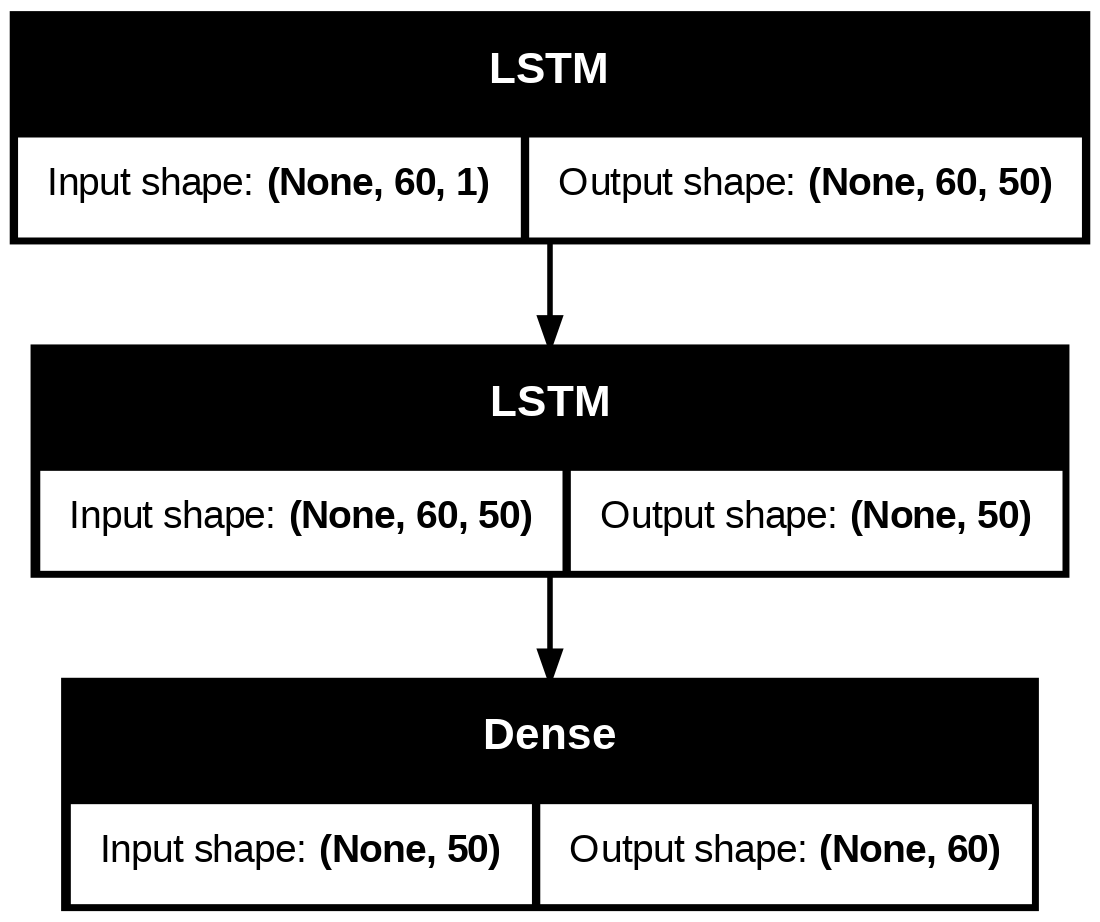

In [ ]:
plot_model(model, show_shapes= True)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X, Y, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - loss: 54280.3281 - val_loss: 48042.8359
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 54316.8398 - val_loss: 47989.5273
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 54018.4180 - val_loss: 47927.7500
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 54089.9453 - val_loss: 47859.8008
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 54089.5430 - val_loss: 47785.1289
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 54006.7734 - val_loss: 47702.4648
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 53899.3359 - val_loss: 47610.1055
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 53804.3867 - val_loss: 47507.8867
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 53767.1953 - val_loss: 47396.5977
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 53567.2227 - val_loss: 47277.2852
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 53443.8906 - val_l

In [ ]:
X_ = y[- n_lookback:] # urutan inputan terakhir
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_)
Y_ = scaler.inverse_transform(Y_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


In [15]:

df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past.loc[df_past.index[-1], 'Forecast'] = df_past['Actual'].iloc[-1]

In [ ]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

In [ ]:
results = df_past._append(df_future).set_index('Date')

<Axes: title={'center': 'APPL'}, xlabel='Date'>

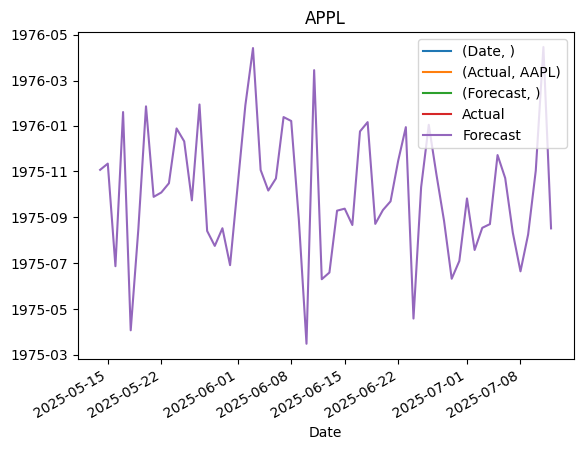

In [ ]:
results.plot(title='APPL')